In [30]:
# in this notebook we will continue the implementation of Make more, but with code more like pytorch
# more context characters than previous implementations
# deeper neural network comapred to single Linear layer + tanh


In [43]:
# imports
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

In [44]:
# dataset
words = open('data/names.txt', 'r').read().splitlines()
# stoi and itos 
chars = set(''.join(words))
stoi = {c:i+1 for i,c in enumerate(sorted(chars))}
stoi['.'] = 0
itos = {v:k for k,v in stoi.items()}

In [45]:
block_size = 3 # no of charcters in context to predict the next one
vocab_size = len(chars)+1 # no of charcacters in vocabulary

def build_dataset(words):# create the traning data 
    X, Y = [], []
    for word in words:
        #running context 
        context = [0]*block_size
        for ch in word+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

#split 
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) #10%
Xte, Yte = build_dataset(words[n2:]) #10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [46]:
# pytorchified code implementation of layers

# similar to torch.nn.Linear
# y = W@X + b 
# fan_in -> in_features (how many signals a neuron listens to)
# fan_out -> out_features (how many signals a neuron speaks to)
# fan_in and fan_out comes from circuit theory 

# class Linear 
class Linear():
    def __init__(self, fan_in,fan_out, bias = True):
        self.weight = torch.randn(fan_in, fan_out) / fan_in**0.5 # kaiming init 
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
# ------------------------------------------------------------
# class BatchNorm
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
# ------------------------------------------------------------   
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
  
# ------------------------------------------------------------

class Embedding:
    def __init__(self, num_embeddings, embeddeing_dim):
        self.weight = torch.randn((num_embeddings, embeddeing_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
# ------------------------------------------------------------

class Flatten:
    def __call__(self,x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    def parameters(self):
        return []
    
# ------------------------------------------------------------
class Sequential:
    def __init__(self, layers):
        self.layers = layers 
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out 
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [47]:
torch.manual_seed(42)

In [48]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)])

#paramter init
with torch.no_grad():
    model.layers[-1].weight  *= 0.1 # make last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

# P requires grad 
for p in parameters:
    p.requires_grad = True

12097


In [49]:
# optimization 
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7491
 120000/ 200000: 2.2891
 130000/ 200000: 2.3443
 140000/ 200000: 2.1731
 150000/ 200000: 1.8246
 160000/ 200000: 1.7614
 170000/ 200000: 2.2419
 180000/ 200000: 2.0803
 190000/ 200000: 2.1326


In [ ]:
plt.plot(lossi)

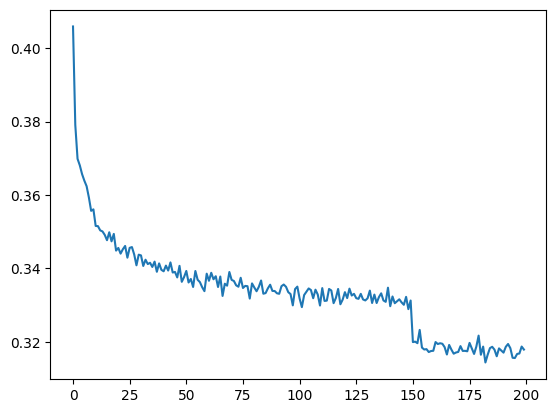

In [50]:
# plot average of consecutive 
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [51]:
# put layers into eval mode
for layer in model.layers:
  layer.training = False

In [52]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0583250522613525
val 2.1065289974212646


In [ ]:
# sample from the model 
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    print(''.join(itos[i] for i in out)) # decode and print the generated word

ivon.
fanili.
thoommara.
kelo.
matyn.
leandr.
aleigh.
koldeniah.
prus.
carleen.
jah.
jorra.
alaya.
shonan.
vishylaharia.
juna.
vio.
orven.
mina.
laylee.
